Imports

In [28]:
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

Defining VAE Network

In [29]:
# 
class VariationalAutoencoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim=200, latent_dim=20):
        super().__init__()
        # encoder
        self.img2hidden = nn.Linear(input_dim, hidden_dim)
        self.hidden2mu = nn.Linear(hidden_dim, latent_dim)
        self.hidden2sigma = nn.Linear(hidden_dim, latent_dim)
        
        # decoder
        self.latent2hidden = nn.Linear(latent_dim, hidden_dim)
        self.hidden2img = nn.Linear(hidden_dim, input_dim)
        
        self.relu = nn.ReLU()

    
    # q_phi(z|x)
    def encode(self, x):
        h = self.relu(self.img2hidden(x))
        mu, sigma = self.hidden2mu(h), self.hidden2sigma(h)
        return mu, sigma
    
    # p_theta(x'|z)
    def decode(self, z):
        h = self.relu(self.latent2hidden(z))
        return torch.sigmoid(self.hidden2img(h))
    
    def forward(self, x):
       mu, sigma = self.encode(x)
       epsilon = torch.randn_like(sigma)
       z = mu + sigma*epsilon
       recon = self.decode(z)
       return recon, mu, sigma

Testing Network

In [6]:
# x = torch.randn(4, 28*28)
# vae = VariationalAutoencoder(input_dim=28*28)
# recon, mu, sigma = vae(x)
# print(recon.shape)

torch.Size([4, 784])


Defining Device and Hyperparameters

In [30]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

INPUT_DIM = 28*28
HIDDEN_DIM = 200
LATENT_DIM = 20
NUM_EPOCHS = 20
BATCH_SIZE = 32
LR_RATE = 0.001

cpu


Loading in Dataset

In [31]:
transform = transforms.ToTensor()

mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_dataset, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True)

Testing Batch Shape

In [35]:
data_iter = iter(data_loader)
images, labels = next(data_iter)
print(images.shape)
print(torch.min(images), torch.max(images))

torch.Size([32, 1, 28, 28])
tensor(0.) tensor(1.)


In [36]:
model = VariationalAutoencoder(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM).to(DEVICE)
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=LR_RATE)
outputs = []

In [37]:
for epoch in range(NUM_EPOCHS):
    # loop = tqdm(enumerate(data_loader), total=len(data_loader))
    for (image, _) in data_loader:
        
        image = image.to(DEVICE).view(image.shape[0], INPUT_DIM)
        recon, mu, sigma = model(image)
        loss = criterion(recon, image)
        kl_div = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
                
        loss = loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    print(image.shape)
    outputs.append((epoch, image, recon))

Epoch:1, Loss:2767.8730
torch.Size([32, 784])
Epoch:2, Loss:2632.8411
torch.Size([32, 784])
Epoch:3, Loss:2656.7800
torch.Size([32, 784])
Epoch:4, Loss:2594.7539
torch.Size([32, 784])
Epoch:5, Loss:2503.3154
torch.Size([32, 784])
Epoch:6, Loss:2397.9788
torch.Size([32, 784])
Epoch:7, Loss:2486.1870
torch.Size([32, 784])
Epoch:8, Loss:2281.8843
torch.Size([32, 784])
Epoch:9, Loss:2263.5728
torch.Size([32, 784])
Epoch:10, Loss:2495.2993
torch.Size([32, 784])
Epoch:11, Loss:2277.5583
torch.Size([32, 784])
Epoch:12, Loss:2303.7952
torch.Size([32, 784])
Epoch:13, Loss:2407.6917
torch.Size([32, 784])
Epoch:14, Loss:2336.6306
torch.Size([32, 784])
Epoch:15, Loss:2303.5105
torch.Size([32, 784])
Epoch:16, Loss:2135.5398
torch.Size([32, 784])
Epoch:17, Loss:2447.9597
torch.Size([32, 784])
Epoch:18, Loss:2416.2141
torch.Size([32, 784])
Epoch:19, Loss:2311.6582
torch.Size([32, 784])
Epoch:20, Loss:2343.7964
torch.Size([32, 784])


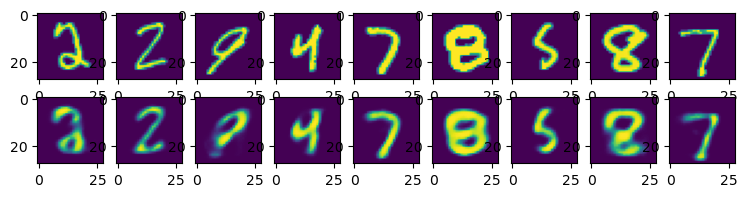

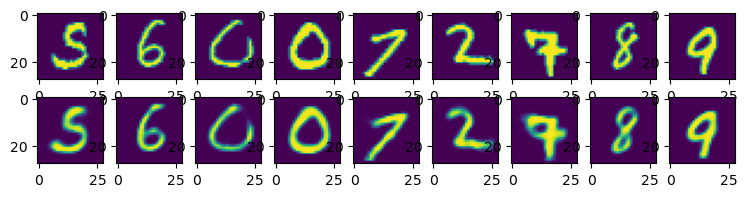

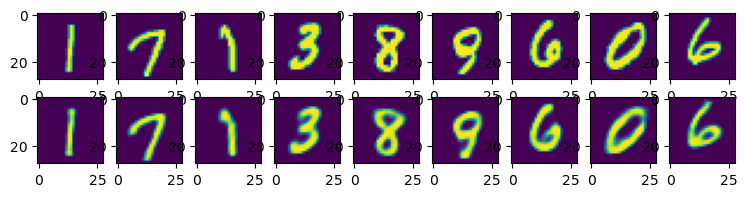

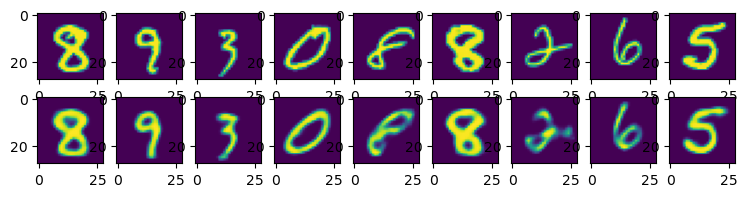

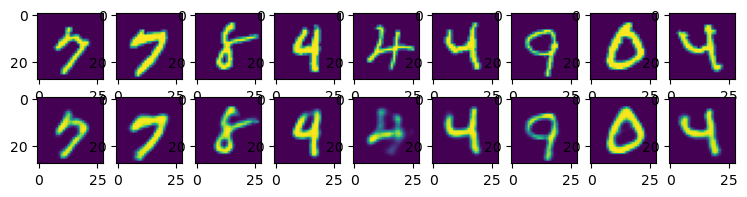

In [40]:
for k in range(0, NUM_EPOCHS, 4):
    plt.figure(figsize=(9, 2))
    # plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()

    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # print(item.shape)
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # # item: 1, 28, 28
        # print(item.shape)
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # # item: 1, 28, 28
        plt.imshow(item[0])